# Explainability Methods Lecture

Author: Ethan Robert A. Casin<br>


---

# Overview

This lecture contains the necessary information the students need to start using interpretable methods for machine learning. We will first dicuss local model-agnostic methods and then global model-agnostic methods. 

The objective today is to equip, at the very least, our students with the local interpretability methods as these are more mathematically rigorous, practical, and can help springboard them to understand the global methods.

---

Why Care about interpretability?
What are the risks involved?

Why not trust:
* the math
* the metrics
* the model
* you?

For this term, we need to understand the data and how it ties into the model?

We do model interpretability would be for decision making.

Blackbox model has an input to an output, but you do not know how you would went through that.

Whitebox model has interpretability in mind during designing it. These are the open-weight/transparent models. You can look at the thorough understanding of their weights.

For local interpretability, we would just like to see what is important in a single decision. For global interpretability, we would like to see the over all model, like which features focus on the whole model.

For model agnostic, it means you can use it for any other model.

# Introduction

Today we'll be learning a very important concept during model development: Explainability. In general, it doesn't just inform us on how the model learns, but also helps us understand our own data. Using the right method, it can aid us in creating actionable recommendations just by understanding how the model came to certain predictions. 

With the push for more transparency in our world, explainability and interpretable methods are at the cornerstone of value creation, impact generation, and even governance in our day-to-day as data scientists. I mean, can we really tell if we created the right model if we don't understand it?

In [1]:
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from IPython.display import display, HTML

warnings.filterwarnings("ignore")
%matplotlib inline

Let's stary by using our old model and data.

In [2]:
data = pd.read_csv("diabetes.csv")
target = data["Outcome"]

X, y = data.iloc[:, :-1], data.iloc[:, -1]

X_Train, X_test, y_Train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0, stratify=target
)

# Creation of a train-validation set
# We'll be adjusting this repeatedly in the notebook
# take note of the capitalized 'Train'.
# The dataframes we'll be primarily using is X_Train and y_Train.
X_train, X_val, y_train, y_val = train_test_split(
    X_Train, y_Train, test_size=0.2, random_state=0, stratify=y_Train
)

# print out the training and validation set sizes
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")

X_train shape: (491, 8)
X_val shape: (123, 8)


In [3]:
model_pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(random_state=1234))
    ]
)

# Model Training
model_pipeline.fit(X_train, y_train)

# Inference
y_preds = model_pipeline.predict(X_val)

# Check performance
print("Performance on the Validation Set:\n")
print(f"F1 Score: {f1_score(y_val, y_preds):.4f}")
print(classification_report(y_val, y_preds))
print("Validation Set Confusion Matrix:\n", pd.DataFrame(confusion_matrix(y_val, y_preds)))

Performance on the Validation Set:

F1 Score: 0.6027
              precision    recall  f1-score   support

           0       0.77      0.90      0.83        80
           1       0.73      0.51      0.60        43

    accuracy                           0.76       123
   macro avg       0.75      0.71      0.72       123
weighted avg       0.76      0.76      0.75       123

Validation Set Confusion Matrix:
     0   1
0  72   8
1  21  22


---

**Interlude: Classification Report**
From the documentation: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

`macro_avg`: Is the mean per label. In the example above the `macro_avg` for precision is (0.77 + 0.73)/2<br>
`weighted_avg`: The support-weighted mean per label. In the above example for precision it is (0.77 * 80 + 0.73 * 43) / (80 + 43)<br>
`micro_avg`: Similar to `macro_avg` but for multiclass classification tasks. Averages the total true positives, false negatives and false positives.

---

**Installing packages**

In [4]:
!pip install shap dice-ml lime --quiet

  DEPRECATION: Building 'lime' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'lime'. Discussion can be found at https://github.com/pypa/pip/issues/6334


**Setting some constants**

In [5]:
FEATURE_NAMES = X_train.columns.tolist()
SEED = 1441
RANDOM_PERSON = X_train.sample(n=1, random_state=SEED)

# Local Model-Agnostic Methods

Let's formally begin our lecture with understanding how to interpret individual data instances. These are useful if we have a certain target example in mind, for diagnostic purposes, and even for prescriptive analytics.

## LIME

LIME is for diagnostic purposes, it can be used by doctors and the such.

forget all about the training data and focus what you currently have. For the purposes of the lecture, we will be using the training data for now.

The decision boundary is the global decision boundary. However, what if you want to predict a certain sample. How would you explain to the certain sample why they were predicted to have diabetes or not. 

Now, we have to deal with the concept of the surrogate model, which is a linear/interpretable model. It can be like a decision tree, lasso/ridge regression and the such. 

LIME will create synthetic points by perturbing youre features. It will try to create a pertubation or a slight variation. Because we are creating synthetic points, when you train the surrogate model, focus only on the local neighborhood. We then try to weight the points in the neighborhood to be of higher importance. This is just an exponential kernel.

The surrogte model is not immune to noise. LIME is very sensitive to the synthetic points, so like is LIME created a point that doesn't make sense, then it can become a problem.

Given the synthetic data points, what doe the linear/surrogate model tell you?

**L**ocal **I**interpretable **M**odel-agnostic **E**xplanations (LIME) is an approach of fitting local surrogate models that are used to explain predictions from black-box models. What is a local surrogate model? In a nutshell, it's an interpretable model we use as a proxy to explain the predictions from another model.

The idea for LIME is simple: forget about the training data and everything and focus on the model you currently have. You can probe this model all you want and your goal is to understand why this model made its prediction. Simply,

- LIME tests what happens to the predictions when you give variations of data to your black-box model
- LIME generates a new dataset, consisting of perturbed samples and the corresponding predictions of the model
- Using this new dataset, LIME trains an interpretable model, which is weighted by the proximity of the sampled instances to our target instance.

*The interpretable model can be anything from Lasso to a decision tree*. 

Because we're focusing on the *local* accuracy, the learned model should be a good approximation of the black-box model's actual predictions for the same instance. However, the learned model from LIME **does not** necessarily have to be a good global approximator. This is called **local fidelity**.

<figure>
    <img src="figures/LIME.png" width=800></img></br>
    <caption>How LIME works. Taken from <a src="https://christophm.github.io/interpretable-ml-book/lime.html#strengths">here</a>. A) is the decision boundary of a black-box model. B) Instance of interest (big dot) and sampled data (black dots). C) Weighted sample points. D) The decision boundary (white line and +/- signs) of the learned model from the weighted samples.</caption>
</figure>

Local surrogate models with an interpretability constraint is generally expressed as 

\begin{equation*}
\text{explanation}(x) = \arg \min_{g\in G} L(\hat{f}, g, \pi_x) + \Omega(g)
\end{equation*}

The explanation model, denoted as $g$, for a target instance $x$, is a model that minimizes a loss function $L$ (e.g. mean-squared error). We measure how close our explanation (from $g$) is to the original prediction of the original model $\hat{f}$. The model complexity $\Omega(g)$ is kept low, e.g.,  use fewer features. 

LIME tries to find the best explanation model $g$ from a family of possible interpretable models $G$. In practice, LIME does this for us automatically so we don't need to bother too much on what model it should use. In some implementaions, the user has to set the model complexity $\Omega(g)$ by specifying the maximum number of features to consider. 

---

**Steps in doing LIME**
1. Select an instance you want to explain
2. Create slight perturbations (changes) to your input dataset and get the black box model's predictions on these new points
3. Weight the new samples according to their proximity to the target instance
4. Train an interpretable model on the new dataset
5. Explain the prediction by interpreting the local model
6. Pick the model that has the lowest error

---

**How does LIME create new points?**
For tabular data, LIME creates new samples by perturbing each feature individually. It changes the values by adding a random value from a normal distribution with mean and standard deviation taken from that feature.

$f$ is the black bax model
$g$ is the surrogate
$\pi_x$ is the surrogate
LIME will find the model for you. The constraint is that the interpretable model should be sparse and linear model such as LASSO, decision tree, and so forth. (LASSO and decision tree are the preferred)

$L(f, g, \pi_x) = \sum_{z \in Z} \pi_x (z) \cdot (f(z) - g(z))$ where $\pi_x(z)$ is the weighting function, so like our weighting function is $\exp\left(-\frac{||x_i - x_{\text{target}}||^2}{\alpha^2} \right)$ where $Z$ are all the data points
For text and image data, you turn single words or super-pixels on or off. Not that relevant for us right now, but I just think you should know.

The misclassification is usually the fault of the black box model. The problem of LIME is creating synthetic data points that dont make sense. The weighting $\alpha$ is not supposed to be a hyperparameter.

We don't deal with the class imbalance because you just use it for the black box model~

another problem is that for each instance, it can create different explanations, but this means that this is not reliable in scale.

Can be used in text and image data

In [6]:
from lime.lime_tabular import LimeTabularExplainer

In [7]:
lime_explainer = LimeTabularExplainer(
    training_data=X_train.values, # LIME wants to use an ndarray instead of a DataFrame
    feature_names=FEATURE_NAMES, 
    class_names=["normal", "diabetic"], # This corresponds to class labels [0, 1]
    mode="classification",
)

# select a random instance 
explained_inst = lime_explainer.explain_instance(
    data_row=RANDOM_PERSON.values[0], # LIME wants an ndarray containing (n_feature,) elements only
    predict_fn=model_pipeline.predict_proba,    
)

display(HTML(explained_inst.as_html()))

In [8]:
for feat, weight in explained_inst.as_list():
    print(f"{feat:40s}  {weight:+.4f}")

Glucose > 141.50                          +0.3248
BMI > 36.30                               +0.2448
Pregnancies <= 1.00                       -0.1292
Age > 41.00                               +0.0613
0.24 < DiabetesPedigreeFunction <= 0.38   -0.0420
BloodPressure > 80.00                     -0.0341
Insulin > 123.50                          -0.0131
SkinThickness > 33.00                     +0.0015


We can see from the results above that the results from LIME are highly interpretable. We find that this random person was predicted to be diabetic by the model, or at the very least, 64% likely to be diabetic. It also shows us how it got to that point. It tells us that our black-box model predicted most likely diabetic because:

1. The Glucose > 141.5
2. The BMI > 36.30
3. The Age > 41

It also provides us why this person is 36% likely to be normal by analyzing the feature values in blue. 

However, LIME is not a perfect method. Here are some strengths and weaknesses for the model.

### Strengths
1. **It is model-agnostic**. Even if you swap out your black-box model, you can still use LIME to exaplin the predictions with the same settings
2. **Explanations are short and humanly interpretable**
3. **Easy to use**
4. **Can use other (interpretable) features.** An advantage of LIME is that even if you trained a model on uninterpretable features, you can still feed it the interpretable features and it will give you reasonable explanations. (See sample below)

In [9]:
from sklearn.decomposition import PCA
sample_pipeline = Pipeline(
    [
        ("decompose", PCA(n_components=4)), # arbitrarily selected n_components
        ("clf", LogisticRegression(random_state=1234))
    ]
)

# Model Training
sample_pipeline.fit(X_train, y_train)

Pipeline(steps=[('decompose', PCA(n_components=4)),
                ('clf', LogisticRegression(random_state=1234))])

In [10]:
lime_explainer = LimeTabularExplainer(
    training_data=X_train.values, # LIME wants to use an ndarray instead of a DataFrame
    feature_names=FEATURE_NAMES, 
    class_names=["normal", "diabetic"], # This corresponds to class labels [0, 1]
    mode="classification",
)

# select a random instance 
explained_inst = lime_explainer.explain_instance(
    data_row=RANDOM_PERSON.values[0], # LIME wants an ndarray containing (n_feature,) elements only
    predict_fn=sample_pipeline.predict_proba,    
)

display(HTML(explained_inst.as_html()))

### Limitations

1. **The choice of neighborhood is still an open problem**. At least at the time of writing, finding the "best" neighborhood is an unsolved problem. This means if you want to be certain you are explaining the target instance correctly, you would have to manually tweak the `kernel_width` settings until it gives you some semblance of reason...if it gives any at all.
2. **Instability in the explanations**. One of the limitations of LIME is that if you try to repeat the sampling process the explanations can be very different. Setting a random seed would be a reasonable choice. However this is more of a band-aid solution.
3. **It can struggle with sparse data**. Because it uses an exponential smoothing kernel (most likely a [Gaussian kernel](https://pages.stat.wisc.edu/~mchung/teaching/MIA/reading/diffusion.gaussian.kernel.pdf.pdf)), it can suffer from the curse of dimensionality. For reference, the weight of a sample point from Gaussian kernel has the form

\begin{equation*}
w_i = \exp\left(-\frac{||x_i - x_{\text{target}}||^2}{\alpha^2} \right)
\end{equation*}

where $\alpha$ is the kernel width parameter. 

<figure>
    <img src="figures/gaussian_kernel.png" width=800></img><br>
    <caption>Sample Gaussian kernel visualization. Image taken <a src="https://dsp.stackexchange.com/questions/10057/gaussian-blur-standard-deviation-radius-and-kernel-size">here</a>.</caption>
</figure>

## SHAP

**SH**apley **A**dditive ex**P**planations (SHAP) is a method to explain model predictions by using a game-theoretic approach called Shapley values. Discussing Shapley values in-depth would require an entire term's worth of time. So let's pick out the things we just need to understand and move on with how this translates to SHAP.

you can use SHAP for images and text, but prof has only used it in images, and it is rlly cool.

### Primer: Shapley Values

In order to understand how SHAP works, we need to form a general idea of Shapley values. The Shapley value is a method of assigning payouts to players depending on their contribution to the total payout. There are a few key concepts to know about Shapley values:

1. **Players**. The features we have in our dataset
2. **Coalition**. A coalition is a group of players. 
3. **Game**. A game is the task that the coalition is doing. For us, it is the model or the prediction task for an instance
4. **Payout**. The output from the game. Basically, the prediction

Now think about it in terms of your LT and you made a product. The question Shapley values tries to answer is: *what is a fair distribution of your profit to each member?* **Shapley values help us understand what is the average contribution of a player to the payout**.

In the context of machine learning, it tells us the average marginal contribution of a feature to the prediction. The intuition of the Shapley value is to compare how the coalition would perform with or without a certain player. 

Suppose you have a team composition like this: weak link, weak-mid link, strong-mid link, strong link. If you remove the strong link, you can expect your team (coalition) to perform worse than if you had him/her. In this straightforward example we could say that the strong link should be paid more. But it's more complicated than that because you need to consider the interactions between players. Suppose you have a situation that your team works best if you have the stron link and the weak-mid link for some reason. Then you would say that the payoff be split among them. 

So to get the true contribution of an individual player, you need to consider subsets of players. Another example is if we remove both the strong link and the weak link, then our team would probably work comparably the same as if we removed the strong link. **The main idea is to compute contribution of a player in each subset and simply averaging over all contributions.** This would give us the *marginal contribution* of that player.


Formally, we define Shapley values as

\begin{equation*}
\phi_i(f, x) = \sum_{z' \subset x'} \frac{|z'|!(M - |z'| - 1)!}{M!}[f_x(z') - f_x(z' \setminus i)]
\end{equation*}

Let's break it down:
1. $\phi_i(f,x)$: is the Shapley value for a specific feature **value** given our black-box model $f$ and input datapoint $x$ (a single row or target instance)
2. $\sum_{z' \subset x'}$: We iterate over all possible subsets $z'$, where $x'$ is our simplified data input (a mapped version of $x$; we generalized it to consider images but not relevant to us now)
3. $[f_x(z') - f_x(z' \setminus i)]$: The contribution of the feature. This is simply the difference of the model's prediction with the feature $f_x(z')$ and without the feature $f_x(z' \setminus i)$ which tells us how much a feature contributed to the prediction in this subset
4. $\frac{|z'|!(M - |z'| - 1)!}{M!}$: Weighting. We essentially weight each feature's contribution (step 3) to the number of players within the subset. $M$ defines the total number features we have.

**What does it mean to remove features?**

Because we can't actually remove features, SHAP tries to randomize the values of features not part of a subset.

When we have $f(z'/i)$, we remove $i$ by just letting it be random. We can't rlly just take it away since that would cause an error in the model. The random is just a normal distribution of $N(\mu, \sigma ^2)$



### How this connects to SHAP

You may have noticed that Shapley values is computationally expensive. To say that SHAP is a rebranding of Shapley values could undermine the contributions of Lundberg and Lee (2017) because they have provided an entirely new way of computing Shapley values while connecting it with LIME.

What SHAP innovates on is that we can represent Shapley values as an additive feature attribution -- a linear model. This view connects SHAPE and LIME, because SHAP defines an explanation model $g$ as

\begin{equation*}
g(\textbf{z}') = \phi_0 + \sum_{i=1}^M\phi_jz'_i,
\end{equation*}

where $\textbf{z}' = [z'_1,\dots,z'_M]^T \in \{0, 1\}^M$ is the coalition vector, $M$ is the maximum coalition size (total number of features), and $\phi_i \in \mathbb{R}$ is the feature attribution for feature $i$. You may notice a new term $\phi_0$ this is essentially the baseline or expected value. This is considered the starting point, where each $\phi_i$ adjustment moves the explanation up or down.

$$\phi_0 = \mathbb{E}[f(x)]$$

Convert the SHAPley values into a linear regression. We can convert it into some form of weight. 

You can have for any class $C$ that you have.
so like you can have $g(z')^C$.

if the shapley value is negative, then it brings the average down. If shap has a negative value, it will predict lower than average. Conversely works as well



### SHAP Properties

There are some properties of SHAP that we need to be aware of. From time to time, we will be calling back to some properties of Shapley values.

#### 1. Local Accuracy

There is a property of Shapley values called **efficiency**, which states that the feature contributions must add up to the difference of prediction for $\mathbf{x}$ and the average

\begin{equation*}
\sum_{i=1}^M\phi_i = f(\mathbf{x}) - \mathbb{E}[f(\mathbf{x})].
\end{equation*}

We can relate this to SHAP by setting our coalition vector's value to all 1's. Specifically, for an instance of interest $\mathbb{x}$ the SHAP formula simplifies to

\begin{equation*}
f(\mathbf{x}) = g(\mathbf{x}') = \phi_0 + \sum_{i=1}^M\phi_i = \mathbb{E}[f(\mathbf{x})] + \sum_{i=1}^M\phi_i
\end{equation*}

Rearranging it should give us the efficiency formula defined above.

#### 2. Missingness

Missingness states that a missing feature gets an attribution of zero. This enforces that missing values get a Shapley value of 0. In practice, this is only relevant to features that are constant.

\begin{equation*}
x'_i = 0 \rightarrow \phi_i = 0
\end{equation*}

Note that $x'_i$ refers to the coalitions where a value of 0 represents an absence of the feature value.

#### 3. Consistency

The consistency property simply states that if a model changes so that the marginal contribution of a feature value increases or stays the same, the Shapley value also increases or stays the same. This ensures that even if you swap out the model, SHAP will never shrink the contribution of a feature. Doing so would undermine the trust in the explainability of a feature. 

Let $f_x(\mathbf{z}') = f_x(h_x(\mathbf{z}'))$ be a new model, where $h_x(\mathbf{z}')$ maps the coalition vector into valid feature values, and $\mathbf{z}'_{-i}$ indicate that we exclude the $i$-th feature $z_i'=0$. For any two models $f$ and $f'$ that satisfy

\begin{equation*}
f_x'(\mathbf{z}') - f_x'(\mathbf{z}'_{-i}) \leq f_x(\mathbf{z}') - f_x(\mathbf{z}'_{-i})
\end{equation*}

for all inputs $\mathbf{z}' \in \{0,1\}^M$, then

\begin{equation*}
\phi_j(f', \mathbf{x}) \leq \phi_j(f, \mathbf{x})
\end{equation*}



### KernelSHAP

In the original paper, the authors proposed KernelSHAP -- the default way of doing SHAP. However, it can be really inefficient for certain algorithms and contexts. The situation is a bit awkward. For example, for tree-based models TreeSHAP offers a faster way of conducting SHAP. DeepSHAP is a more efficient way for Deep Neural Networks. However, we can gain an understanding for these different variants by understanding KernelSHAP.

---

**Steps in KernelSHAP**
1. Sample coalition vectors $\mathbf{z}'_k \in \{0,1\}^M, \ k \in \{1, \dots, K\}$, where (1=feature is present in coaltion, 0 otherwise)
2. Get a prediction for each coalition by converting $\mathbf{z}'$ to the original feature space and then applying the model $f: f(h_x(\mathbf{z}'_k))$
3. Compute the weight for each coalition $\mathbf{z}'_k$
4. Fit the weighted linear model
5. Return the Shapley values $\phi_k$

---

You are now constrained to the time complexity of a linear model for KernelSHAP, not the O(2^n)

In [11]:
import shap

shap.initjs() # Enables us to generate SHAP plots

### Implementation

Let's use the same random person and compare it with our LIME explanations.

In [12]:

# By convention, the positive (1) class is usually found in our second column.
# For standards, class labels [0, 1, ...] have the corresponding
# ordered index within SHAP, i.e., [0, 1, ...]
class_idx = 1

# If you want to be specific to any classes, then 
# you filter the column in the model_fn already.
# Ex: model_fn = lambda x: model_pipeline.predict_proba(x)[:, class_idx]
# Just make sure to adjust everything if you do so.

model_fn = lambda x: model_pipeline.predict_proba(x)


shap_explainer = shap.KernelExplainer(
    model=model_fn,
    data=X_train,
    feature_names=FEATURE_NAMES,
    link="logit", # since we're predicting probabilities, we set this to "logit"
)

# We index it to 0 first, because if you ask shap to get SHAP values for N rows,
# you get an array of shape (N, n_features, n_classes)
# We index it to 0 because we just want to get our instance SHAP values
shap_values = shap_explainer.shap_values(RANDOM_PERSON)[0][:, class_idx]

Using 491 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

In [13]:
for fname, val in zip(FEATURE_NAMES, shap_values):
    print(f"{fname:20s}{val:+.4f}")

Pregnancies         -0.3805
Glucose             +0.5521
BloodPressure       -0.0883
SkinThickness       -0.0080
Insulin             -0.0467
BMI                 +1.1461
DiabetesPedigreeFunction-0.0952
Age                 +0.1364


In [14]:
shap.force_plot(shap_explainer.expected_value[class_idx], shap_values, feature_names=FEATURE_NAMES)

Visually we can see that there are some similarities with LIME, such that BMI, was the identified key feature for this person, next is Glucose, and last is the Age. We also find similarities in which "pull down" the SHAP value. We also find that our SHAP value is above our `base value` meaning that SHAP identified that this person is diabetic.

To make things more concrete on how to interpret the SHAP values, let's look at a person who is not diabetic.

base value - expected value/mean

SHAP
- doesnt give you probabilities
- feature importance locally
-just contribution of freatures
- a little less interpreable than line

In [15]:

# By convention, the positive (1) class is usually found in our second column.
# For standards, class labels [0, 1, ...] have the corresponding
# ordered index within SHAP, i.e., [0, 1, ...]
class_idx = 1

# If you want to be specific to any classes, then 
# you filter the column in the model_fn already.
# Ex: model_fn = lambda x: model_pipeline.predict_proba(x)[:, class_idx]
# Just make sure to adjust everything if you do so.

model_fn = lambda x: model_pipeline.predict_proba(x)


shap_explainer = shap.KernelExplainer(
    model=model_fn,
    data=X_train,
    feature_names=FEATURE_NAMES,
    link="logit", # since we're predicting probabilities, we set this to "logit"
)

# We index it to 0 first, because if you ask shap to get SHAP values for N rows,
# you get an array of shape (N, n_features, n_classes)
# We index it to 0 because we just want to get our instance SHAP values
np.random.seed(0)
random_idx = np.random.randint(low=0, high=X_train.shape[0])
shap_values = shap_explainer.shap_values(X_train)[random_idx][:, class_idx]

Using 491 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/491 [00:00<?, ?it/s]

In [17]:
for fname, val in zip(FEATURE_NAMES, shap_values):
    print(f"{fname:20s} {val:+.4f}")

Pregnancies          -0.4699
Glucose              -0.2857
BloodPressure        +0.1199
SkinThickness        +0.0026
Insulin              +0.0150
BMI                  -0.9379
DiabetesPedigreeFunction -0.2092
Age                  -0.1276


In [18]:
shap.force_plot(shap_explainer.expected_value[class_idx], shap_values, feature_names=FEATURE_NAMES)

Notice how the SHAP value is below the `base value`.

### Bonus: TreeExplainer

Just to add to your tool belt, we can use the `TreeExplainer` in case you want to use it on DecisionTrees, RandomForest, XGBoost, and other tree-based models.

In [17]:
from sklearn.ensemble import RandomForestClassifier

In [18]:
rf_pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("clf", RandomForestClassifier(random_state=1234))
    ]
)

# Model Training
rf_pipeline.fit(X_train, y_train)

# Inference
y_preds = rf_pipeline.predict(X_val)

# Check performance
print("Performance on the Validation Set:\n")
print(f"F1 Score: {f1_score(y_val, y_preds):.4f}")
print(classification_report(y_val, y_preds))
print("Validation Set Confusion Matrix:\n", pd.DataFrame(confusion_matrix(y_val, y_preds)))

Performance on the Validation Set:

F1 Score: 0.6133
              precision    recall  f1-score   support

           0       0.78      0.89      0.83        80
           1       0.72      0.53      0.61        43

    accuracy                           0.76       123
   macro avg       0.75      0.71      0.72       123
weighted avg       0.76      0.76      0.75       123

Validation Set Confusion Matrix:
     0   1
0  71   9
1  20  23


In [19]:
tree_explainer = shap.TreeExplainer(
    model=rf_pipeline.named_steps["clf"],
    data=X_train,
    feature_names=FEATURE_NAMES
)
shap_values = tree_explainer.shap_values(RANDOM_PERSON)[0][:, class_idx]

shap.force_plot(tree_explainer.expected_value[class_idx], shap_values, feature_names=FEATURE_NAMES)

### Strengths

There are a couple of strengths with SHAP, namely,

1. **The prediction is fairly distributed among the features.** This goes without saying that we don't have to worry about having an imbalanced view of feature contributions to a particular prediction.
2. **Connects to LIME**. Like many innovations, connecting the new to the established is a guaranteed way of its practicality.
3. **Enables for global interpretations**. Generally, SHAP was built for local interpretations of predictions. But the innovation on how to compute for Shapley values enables us to do some aggregations to gain a more global interpretation of our model (more on that later)

### Limitations

1. **KernelSHAP is slow**. This makes it impractical to use at scale
2. **KernelSHAP ignores feature dependence**. By replacing feature values with values from random instances, it is usually easier to randomly sample from the marginal distribution. However, if features are dependent, e.g., correlated, this leads to putting too much weight on unlikely data points.
3. **TreeSHAP can produce unintuitive explanations**. Although TreeSHAP improves on KernelSHAP for tree-based methods, it does so at the cost of changing the value function. With this, features that have no contribution on the prediction can have a Shapley value other than 0.
4. **Shapley values and SHAP can be easily misinterpreted.** This also means you may unintentionally hide biases. For data scientists, it's not a problem provided they understand SHAP. However, the people who get the explanation may find it hard to be sure about the truthfulness of the explanations.

# Counterfactuals

If i had predicted to JOhn that he was 90% diabetic, then what should be the contrapositive.

Counterfactuals are an interesting and very useful method of explainability. Compared to the previous two methods above, counterfactuals tend to be geared toward action in many practical cases.

A counterfactual explanation describes a causal situation in the form: "If X had not occurred, Y would not have occurred." For example, "if I had brought my umbrella, I wouldn't have been drenched by rain."

<figure>
    <img src="figures/counterfactuals.jpg" width=800></img><br>
    <caption>Causal relationships between inputs of a machine learning model to its predictions. Though it does not reflect the actual causal relationship. Image taken <a src="https://christophm.github.io/interpretable-ml-book/counterfactual.html">here</a>.</caption>
</figure>

Let;s just treat the x1 to xn as a causal variable (even tho not rlly) to y.
Looking at this graph, the idea of counterfactuals are pretty simple: change the feature value of an instance before making a prediction and analyze how it changes. What we're really interested in is creating scenarios wherein the predictions change in a relevant way, like a flip in a predicted class, or a prediction reaches a certain threshold.

Therefore, **a counterfactual explanation of a prediction describes the smallest change to the feature values that changes the prediction to a predefined output.**

> For your FYI, counterfactuals are sometimes called contrastive explanations in the literature.

In theory, there are various ways of computing counterfactuals. Discussing just one might provide some insight, but we might lose sight on the bigger picture. The main idea of counterfactuals is basically having to minimize a distance between the target instance $\mathbf{x}$ and its counterfactual $\mathbf{x}'$. Basically, 

\begin{equation*}
\min d(\mathbf{x}, \mathbf{x}')
\end{equation*}

such that $|f(\mathbf{x}') - y'| \leq \epsilon$, where $y'$ is the desired outcome and $\epsilon$ is our tolerance. We basically want to find or create a counterfactual $\mathbf{x}'$ in such a way that the prediction of our model $f$ is as close as possible to our desired outcome.

### Implementation

We can use `dice_ml` to help us create our counterfactuals.

In [19]:
import dice_ml
from dice_ml import Data, Model, Dice

In [20]:
train_data = X_train.join(y_train) # we need to include our target in the df

# We first create our DiCE input data
dice_df = Data(dataframe=train_data, continuous_features=FEATURE_NAMES, outcome_name="Outcome")

# Then we "endorse" our model to DiCE
dice_model = Model(model=model_pipeline, backend="sklearn", model_type="classifier")

In [21]:
dice_exp = Dice(dice_df, dice_model) # We generate our DiCE explainer

In [22]:
# the total_CFs parameter helps us generate n counterfactuals for us to choose from
# We also set what our desired outcome is or a certain threshold we want to meet (usually for regression)
cfs = dice_exp.generate_counterfactuals(RANDOM_PERSON, total_CFs=4, desired_class=0)

100%|██████████| 1/1 [00:00<00:00, 19.09it/s]


In [23]:
cfs.visualize_as_dataframe(show_only_changes=True) # only show the values that changed

Query instance (original outcome : 1)


Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin        BMI  \
0            1      144             82             46      180  46.099998   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.335   46        1


Diverse Counterfactual set (new outcome: 0)


Pregnancies Glucose BloodPressure SkinThickness Insulin BMI  \
0           -    29.0             -             -       -   -   
1           -    40.0             -          37.0       -   -   
2           -   104.0             -          38.0       -   -   
3         3.0    81.0             -             -       -   -   

  DiabetesPedigreeFunction   Age Outcome  
0                        -  58.0     0.0  
1                        -     -     0.0  
2                        -     -     0.0  
3                        -     -     0.0

You might notice that the counterfactuals may be random, unfeasible, or non-sensical. After all the point of counterfactuals is to **change the values of features we can actually change or act upon**. A bad example would be if our counterfactual suggested we "lower our age", which is basically impossible unless you have a time machine or a age doohickey.

A really good way of visualizing what we mean is an image from DiCE
<figure>
    <img src="figures/counterfactuals_dice.png" width=800></img><br>
    <caption>Counterfactual explanations by DiCE. Image taken <a src="https://github.com/interpretml/DiCE?tab=readme-ov-file">here</a>.</caption>
</figure>

We can therefore, add constraints to our counterfactuals that would follow something feasible or sensible. This can be done using the `features_to_vary` parameter.

In [25]:
cfs = dice_exp.generate_counterfactuals(
    RANDOM_PERSON, total_CFs=4, desired_class=0,
    features_to_vary=["BMI"]
)
cfs.visualize_as_dataframe(show_only_changes=True)

100%|██████████| 1/1 [00:00<00:00, 21.37it/s]

Query instance (original outcome : 1)


Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin        BMI  \
0            1      144             82             46      180  46.099998   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.335   46        1


Diverse Counterfactual set (new outcome: 0)


Pregnancies Glucose BloodPressure SkinThickness Insulin   BMI  \
0           -       -             -             -       -   4.1   
1           -       -             -             -       -  18.7   
2           -       -             -             -       -  13.7   
3           -       -             -             -       -  23.3   

  DiabetesPedigreeFunction Age Outcome  
0                        -   -     0.0  
1                        -   -     0.0  
2                        -   -     0.0  
3                        -   -     0.0

### Rashomon Effect

You may then be wondering, well which counterfactual is the best? Well maybe all of them, none of them, some of them, what ever is best for you. This conundrum of having no definite or best situation is called the [Rashomon effect](https://en.wikipedia.org/wiki/Rashomon_effect). In filmmaking, the Rashomon effect is often described as the situation where people recall the same event in very different, yet plausible ways. 

In our context, we can see that we can have different counterfactuals (plausible situations) that have the same effect on our predictions. Which is why we generally want to produce more than 1 counterfactual and pick out the best one. 

**Best practice for the number of counterfactuals?** None. It's up to you.

### Strengths

1. **Interpretations are very clear and actionable**
2. **Counterfactuals don't require access to the data or model**
3. **Easy to implement**


## Limitations

1. **The Rashomon effect**
2. **Not as useful for understanding models or gaining data insights**

# Global Model-Agnostic Methods

We've now seen how to interpret models based on chosen instances, but what about explaining a model as a whole? Is there a way to do that? Yes, in several different ways.

## Feature Importance

The most standard of which is the feature importance. Feature importances take advantage of the learned weights of certain models or from certain characteristics of models. As you may have guessed it by now, not all models have this feature built-in. Decision trees and other tree-based methods leverage the **drop / reduction in impurity (e.g., MSE drop)**. Usually, feature importance in these models are computed as the total impurity reduction contributed by splits on a feature, averaged over trees

In [26]:
feat_imps = rf_pipeline.named_steps["clf"].feature_importances_
idx_order = np.argsort(-feat_imps) # we do a negative to ensure we do it in desc order
ordered_imps = np.take_along_axis(feat_imps, idx_order, axis=0)
ordered_labels = np.take_along_axis(np.array(FEATURE_NAMES), idx_order, axis=0)

plt.figure(figsize=(10,5))
sns.barplot(x=ordered_imps, y=ordered_labels)
plt.show()

NameError: name 'rf_pipeline' is not defined

There is a way to estimate the feature importances of some models, like the `LinearRegression`, and it is by using the [standard error](https://en.wikipedia.org/wiki/Standard_error) $\text{SE}$ and the model's estimated coefficients or weights $\beta_j$ for the $j$-th feature. Specifically, we compute the [t-statistic](https://en.wikipedia.org/wiki/T-statistic) which is defined as

$$t_{\beta_j} = \frac{\beta_j}{\text{SE}(\beta_j)}$$

In [27]:
def standard_error(y, X, beta, robust=False):
    y = np.asarray(y).reshape(-1)
    X = np.asarray(X)
    beta = np.asarray(beta).reshape(-1)

    n, k = X.shape
    resid = y - X @ beta

    # Use rank-based dof (handles multicollinearity)
    rank = np.linalg.matrix_rank(X)
    dof = max(n - rank, 1)

    # Numerically safer than raw inverse
    XtX_inv = np.linalg.pinv(X.T @ X)

    if robust:
        xe = X * resid[:, None]            # broadcasts resid across columns
        meat = xe.T @ xe                   # equivalent to X' diag(e^2) X
        cov = XtX_inv @ meat @ XtX_inv
    else:
        sigma2 = (resid @ resid) / dof
        cov = sigma2 * XtX_inv

    se = np.sqrt(np.clip(np.diag(cov), 0, np.inf))
    return se

def t_stats(beta, se):
    beta = np.asarray(beta).reshape(-1)
    se = np.asarray(se).reshape(-1)
    with np.errstate(divide='ignore', invalid='ignore'):
        t = beta / se
    return t

def t_stat(y, X, beta, robust=False):
    return t_stats(beta, standard_error(y, X, beta, robust=robust))

In [28]:
weights = model_pipeline.named_steps["clf"].coef_
SE = standard_error(y_train, X_train, weights)
feat_imps = t_stat(y_train, X_train, weights)

fitted_summary = pd.DataFrame(
    data={
        "feature": FEATURE_NAMES,
        "weight": weights[0],
        "SE": SE,
        "|t|": feat_imps,
    },
).sort_values(by="|t|", ascending=False).set_index("feature")

print("=" * 55)
print("Feature Importances:")
print(fitted_summary)
print("=" * 55)

Feature Importances:
                            weight         SE       |t|
feature                                                
Glucose                   0.956345   0.195540  4.890776
BMI                       0.741558   0.822239  0.901877
Pregnancies               0.526371   2.046428  0.257214
Age                       0.156122   0.610590  0.255691
DiabetesPedigreeFunction  0.279579  18.440040  0.015162
SkinThickness            -0.006230   0.460768 -0.013521
BloodPressure            -0.168638   0.319841 -0.527255
Insulin                  -0.061129   0.064703 -0.944759


### Strengths
1. **Fast and easy to retrieve**
2. **Good for initial checks in development**


### Limitations

1. **Not as actionable**
2. **Tends to be model dependent**
3. **Cannot be standardized for all models**
4. **Interpretation of the weights may need to be contextualized with the preprocessing**

Limitation (said in class) for feature importance
1. model dependent
2. dependence on the scales/magnitudes of the feature
3. not all models have a feature importance measure

## Permutation Importance

We've seen that feature importance, thought useful, may not be as available to us if we want to use different models. Is there a way we can measure the importance of our features without being too dependent on our model? Well, you guessed it...

Permutation feature importance (PFI) measures the increase in prediction error of the model after we permute the values of the feature. This, in turn, breaks the relationship between the feature and the outcome. The idea is simple: **a feature is important if shuffling its values leads to a high error**. If that's the case, then it means the model relied heavily on that feature.

In [29]:
from sklearn.inspection import permutation_importance

In [30]:
perm_imp = permutation_importance(model_pipeline, X_train, y_train, scoring="f1", random_state=SEED, n_repeats=5)
perm_imp

{'importances_mean': array([ 0.0504027 ,  0.20228056, -0.0055672 ,  0.        ,  0.00070402,
         0.07424149,  0.00869301,  0.00117104]),
 'importances_std': array([0.00632346, 0.0366665 , 0.00558664, 0.        , 0.0049228 ,
        0.02287939, 0.00475841, 0.00936647]),
 'importances': array([[ 0.04590164,  0.05051769,  0.0412716 ,  0.05559223,  0.05873033],
        [ 0.25073106,  0.21164652,  0.17797649,  0.22511453,  0.14593421],
        [-0.01109873, -0.00913424, -0.00294667,  0.00418647, -0.00884285],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.00418647, -0.00443587, -0.00232819, -0.00253834,  0.00863602],
        [ 0.10013929,  0.06154187,  0.04856354,  0.1033738 ,  0.05758894],
        [ 0.00831874,  0.00971156,  0.00625931,  0.0168165 ,  0.00235892],
        [-0.0108424 ,  0.00048248, -0.00620648,  0.01556024,  0.00686136]])}

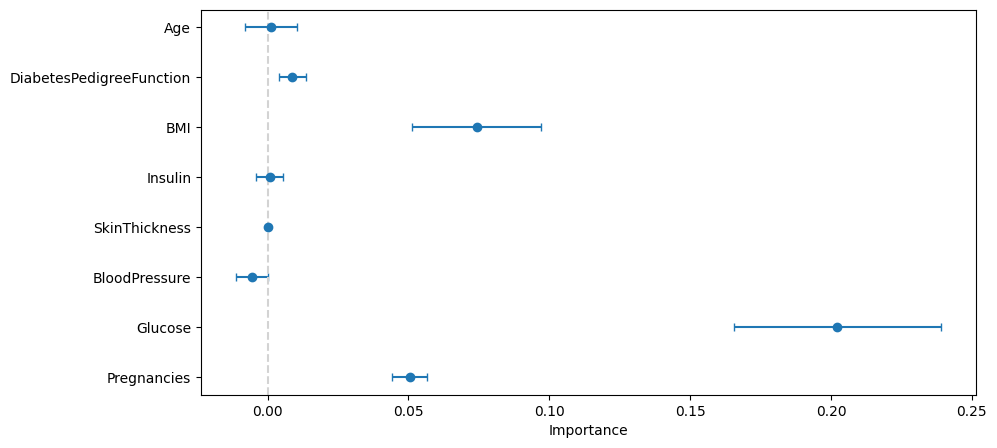

In [31]:
plt.figure(figsize=(10, 5))

plt.errorbar(x=perm_imp["importances_mean"], y=FEATURE_NAMES, xerr=perm_imp["importances_std"], fmt="o", capsize=3)
plt.xlabel("Importance")
plt.axvline(0, linestyle="--", c="lightgray")
plt.show()

### Strengths

1. **Easy Interpretation**
2. **Useful for general data insights**
3. **Takes into account all interactions**
4. **Does not require retraining**

### Limitations

1. **Doesn’t tell you how the feature influences the prediction**
2. **Need access to the true outcome**
3. **Results might vary greatly**. Repeating the permutation and getting the average can lead to more stable results, but it can take more compute time.
4. **Can be biased by unrealistic data instances**

## Partial Dependence Plot

We've learned so far how to understand which features are important. But what about what the model learned on the features? How does the model "see" feature interactions and effects on the predicted outcome in general? At least at this point, we know how it works on a per instance level. But what about in general?

Partial dependence plots (PDPs) shows us the marginal effect one or two features have on the predicted outcome. A PDP can show whether the relationship between a feature and its outcome are linearly related, monotonically related, or complex-ly related. For example in a linear regression, PDPs always show a linear relationship.

The partial function $f_s$ is estimated by calculating the averages in the training data, also known as the Monte Carlo method:

\begin{equation*}
f_s(x_s) = \frac{1}{n}\sum_{i=1}^nf(x_s,x_c),
\end{equation*}

where $x_c$ are the actual feature values for the feature(s) we're not interested in, $x_s$ are the feature values we want to measure the effect on the prediction, and $f$ is our machine learning model.

---

**Procedure**

1. For each value of the feature of interest, replicate the dataset and use the chosen value for that feature
2. Run the model to get the predictions
3. Average the predictions
4. Plot it

---

### Implementation

The implementation is relatively straight-forward

In [32]:
from sklearn.inspection import PartialDependenceDisplay

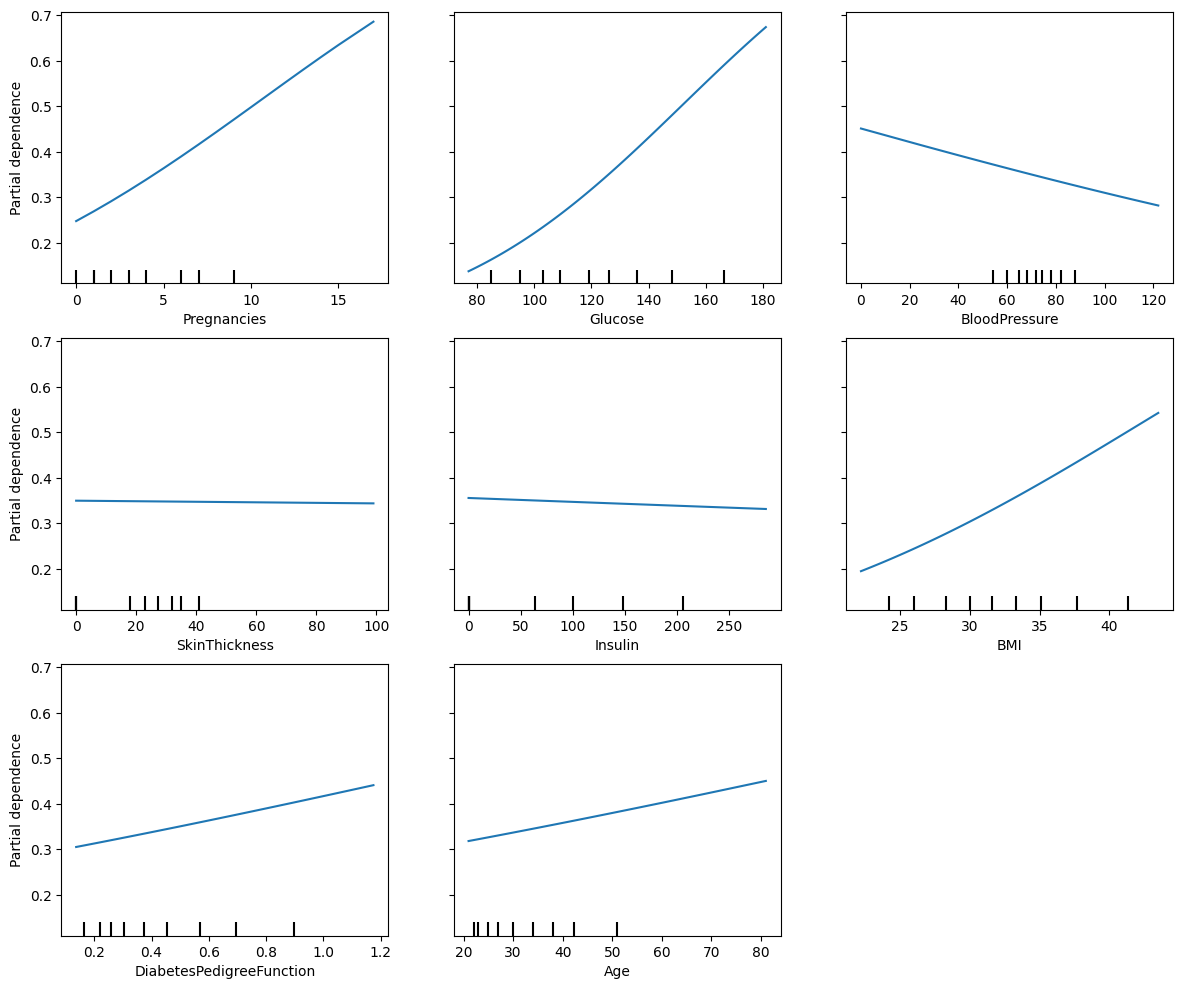

In [33]:
fig, ax = plt.subplots(figsize=(12, 10))
disp = PartialDependenceDisplay.from_estimator(
    model_pipeline, X_train, np.arange(X_train.shape[1]), ax=ax
)
plt.tight_layout()

You may notice something, we passed the entire `Pipeline` object to our PDP function.

**What happens if you remove the scaling from the PDP plot?**

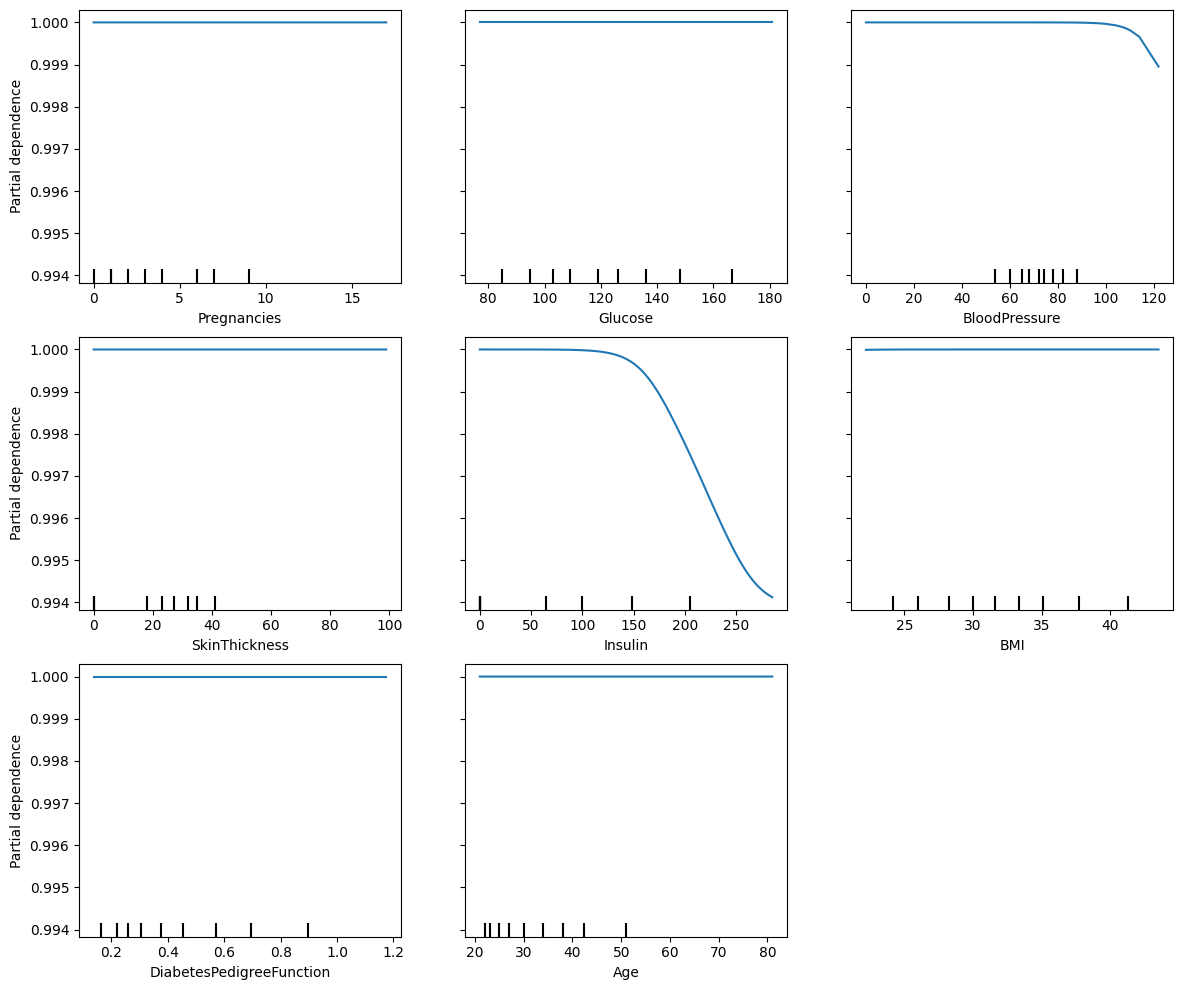

In [34]:
model_clf = model_pipeline.named_steps["clf"]

fig, ax = plt.subplots(figsize=(12, 10))
disp = PartialDependenceDisplay.from_estimator(model_clf, X_train, np.arange(X_train.shape[1]), ax=ax)

plt.tight_layout()

This highlights that we need to be careful on what we pass to our PDP function. If we trained our model to do certain preprocessing steps, then we need to contextualize our PDP accordingly as well. If not, you'll get results like these.

### 2D PDP

There are times when you need to drill down more on certain feature interactions. PDPs offer a way to understand how two features interact and how it affects the predicted outcome. From the plot below, you can clearly see certain boundaries and their associated outcomes. PDPs offer a quick and practical way in explaining models.

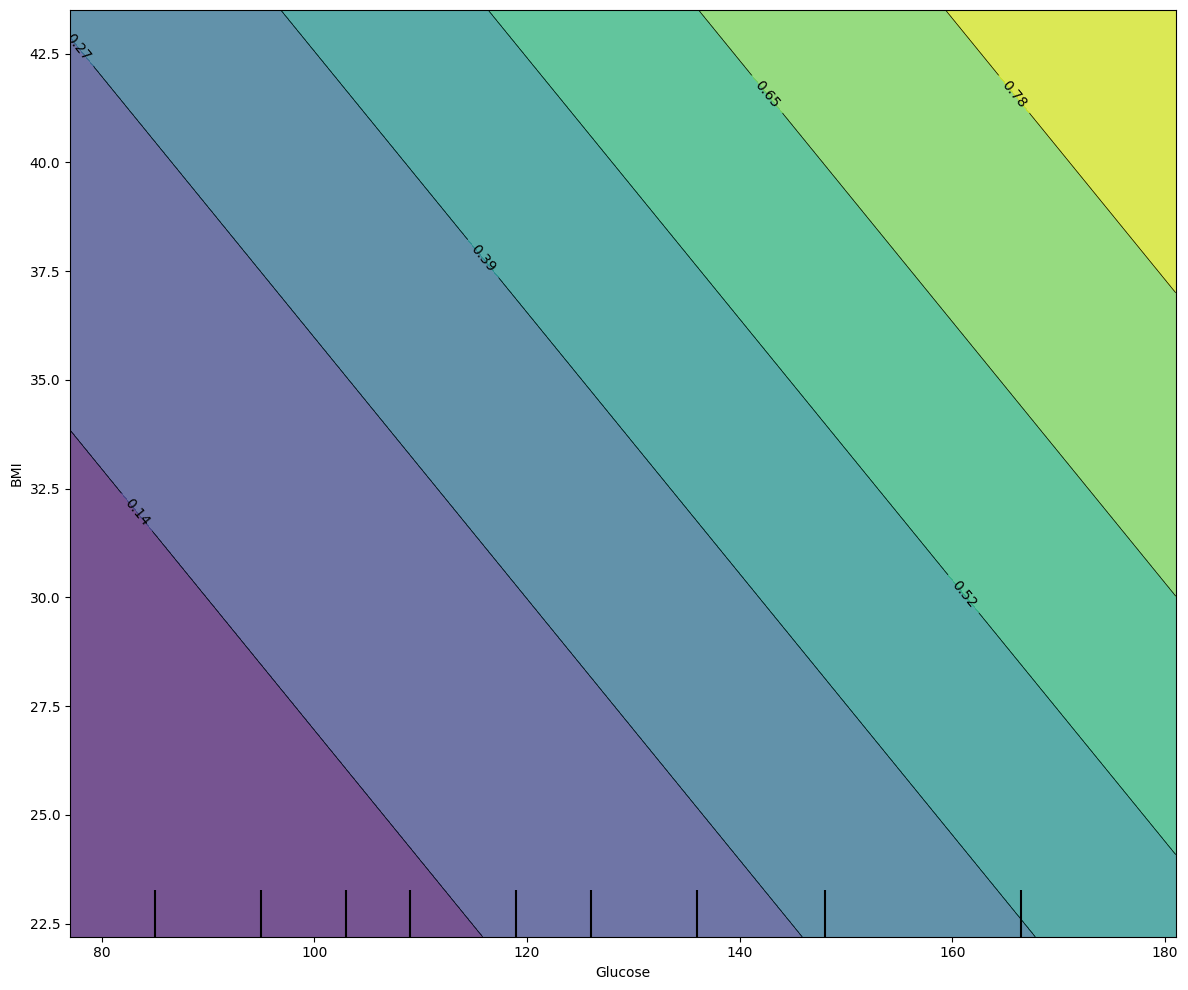

In [35]:
fig, ax = plt.subplots(figsize=(12, 10))
disp = PartialDependenceDisplay.from_estimator(
    model_pipeline, X_train, features=[(1, 5)], ax=ax
)
plt.tight_layout()

### Strengths

1. **The plots are intuitive**
2. **Interpretation is clear**
3. **Easy to implement**

### Limitations
1. **You can only visualize up to 2 features at a time (2D PDP)**. This makes sense, because we have the limitation of "seeing" beyond 3D. In the 2D PDP, what is your "third" dimension?
2. **Omits the feature distribution**. The feature distributions could provide more context on certain regions of the PDP. However, because we're averaging it we don't see these nuances.
3. **Assumes feature independence**. This is arguably the biggest issue with PDPs. When the features are correlated, we create new data points in areas of the feature distribution where the actual probability is very low. A remedy is to use ALE plots.
4. **Heterogeneous effects might be hidden** because PD plots only show the average marginal effects. Suppose that for a feature half your data points have a positive association with the prediction – the larger the feature value, the larger the prediction – and the other half have a negative association – the smaller the feature value, the larger the prediction. The PD curve could be a horizontal line since the effects of both halves of the dataset could cancel each other out. You then conclude that the feature has no effect on the prediction. 

## Revisited: SHAP for Global Interpretability

As mentioned before, we can try to do some form of aggregation to our Shapley values to generate an global view of our model. A standard implementation of Shap for global interpretability is a summary plot using a `beeswarm` plot.

In [36]:
model_fn = lambda x: model_pipeline.predict_proba(x)

shap_explainer = shap.KernelExplainer(
    model=model_fn,
    data=X_train,
    feature_names=FEATURE_NAMES,
    link="logit", # since we're predicting probabilities, we set this to "logit"
)

shap_values = shap_explainer.shap_values(X_train)

Using 491 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 491/491 [00:06<00:00, 74.99it/s]


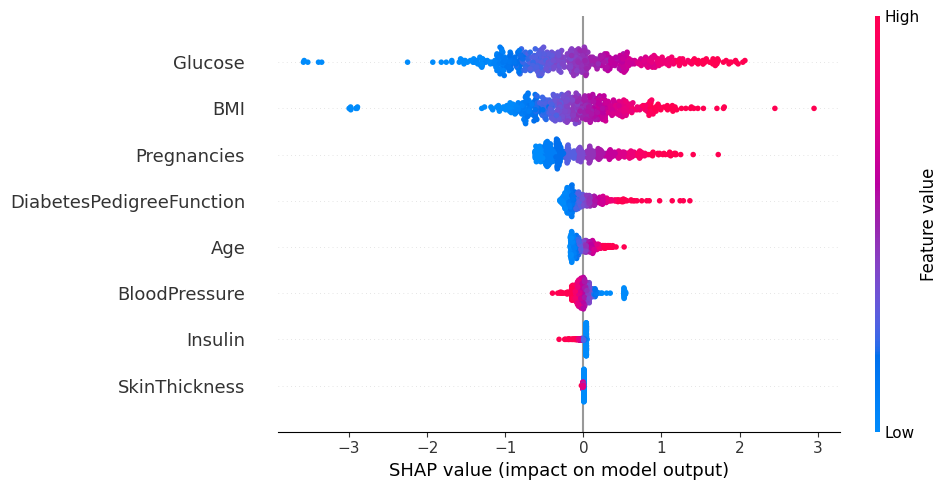

In [37]:
shap.summary_plot(shap_values[:, :, class_idx], X_train, plot_size=(10,5))

The plot above shows us that high values of `Glucose` results in a prediction likely towards the positive class (1). We also find the same insight on `BMI` and `Pregnancies`. We can also see that SHAP provides us with the distribution of the features and how that translates to the Shapley values. An often useful tool in interpreting models.

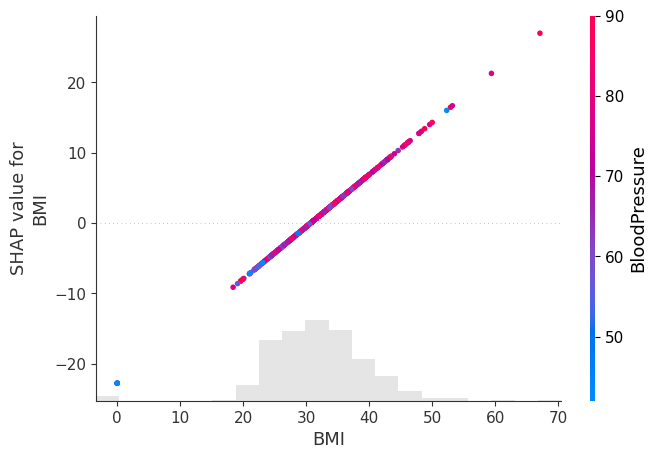

In [38]:
# Sometimes the SHAP library can be inconsistent

explainer = shap.Explainer(model_pipeline.named_steps["clf"], X_train)
shap_values_exp = explainer(X_train)

shap.plots.scatter(shap_values_exp[:, "BMI"], color=shap_values_exp)

# Exercise

What does it mean if you do your interpretations on the validation/test set instead of the training set?

Combine what you've learned from handling class imbalance to develop your own methodology and explain your results.

# References

[1] Lundberg, Scott M., and Su-In Lee. 2017. “A Unified Approach to Interpreting Model Predictions.” In Proceedings of the 31st International Conference on Neural Information Processing Systems, 4768–77. NIPS’17. Red Hook, NY, USA: Curran Associates Inc. <br>
[2] Molnar, C. (2025). Interpretable Machine Learning: A Guide for Making Black Box Models Explainable (3rd ed.). christophm.github.io/interpretable-ml-book/